# Engineering of Data Analysis: assignment 1

By delivering this notebook, we confirm that the code presented was developed by the following students.

**Student num:** 52255     **; Name:** Bastien Gobet

**Student num:** 56466     **; Name:** Tomas Oliveira

**DEADLINE:** 21st April, 23h59

**Only one student should deliver the notebook**


**IMPORTANT:** To use GPUs in Colab, you need to go to the menu ```Edit > Notebook settings``` and select GPU as the hardware accelerator.

Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [CuDF documentation](https://docs.rapids.ai/api/cudf/stable/)
* [cuML documentation](https://docs.rapids.ai/api/cuml/stable/)


# Install software

In [ ]:
# Software to download files
!pip install gdown

In [ ]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 120 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.14+7-1~22.04.1 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.14+7-1~22.04.1 [71.3 MB]
Fetched 120 MB in 6s (20.1 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ...

In [ ]:
# Install RAPIDS - for using cuDF, cuML
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible,
# it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 8.47 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Resolved 173 packages in 1.95s
 Downloaded rmm-cu12
 Downloaded cuproj-cu12
 Downloaded shapely
 Downloaded cudf-cu12
 Downloaded pylibcugraph-cu12
 Downloaded datashader
 Downloaded libkvikio-cu12
 Downloaded dask
 Downloaded ucx-py-cu12
 Downloaded cuspatial-cu12
 Downloaded cucim-cu12
 Downloaded librmm-cu12
 Downloaded cuml-cu12
 Downloaded cugraph-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded libcuml-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuvs-cu12
 Downloaded libcugraph-cu12
 Download

# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing. For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/assignment1

Mounted at /content/drive
sample.csv.gz  sorted_data.csv.gz  tiny.csv.gz


Next cells setup: Pandas, Spark and cuDF/cuML.

In [ ]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster


In [ ]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
import pyspark.pandas as ps

# this sets the maximum number of rows to show when printing pandas Dataframes
ps.set_option('display.max_rows', 10)



/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
# Imports for cuDF / cuML

import cudf
import cupy as cp
import cuml.cluster

In [ ]:
# Setup the dataset being used

# Large dataset - 12.3 GB compressed
#FILENAME = "/content/drive/MyDrive/assignment1/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
FILENAME = "/content/drive/MyDrive/assignment1/sample.csv.gz"

# Tiny dataset - 6.8 MB compressed (you can use this one for speeding up development only)
#FILENAME = "/content/drive/MyDrive/assignment1/tiny.csv.gz"


## Simple statistics

We will print some simple statistics.

In [ ]:
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

statistics = spark.sql( """SELECT COUNT( DISTINCT medallion) AS num_medallion,
                                  COUNT( DISTINCT hack_license) AS num_license,
                                  MIN( pickup_datetime) AS min_pickup,
                                  MAX( dropoff_datetime) AS max_dropoff,
                                  MAX( trip_time_in_secs) AS max_trip_time,
                                  MAX( trip_distance) AS max_trip_distance,
                                  MAX( total_amount) AS max_total_amount
                                  FROM data""")
statistics.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|num_medallion|num_license|         min_pickup|        max_dropoff|max_trip_time|max_trip_distance|max_total_amount|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|        10867|      20354|2013-01-01 00:00:00|2013-01-21 00:11:45|        10800|            95.85|           465.0|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+

Runtime = 19.219141006469727


## Ploting information

Example on how to plot information using matplotlib.

### First plot

This first plot helps showing that data has several invalid values.

Let's plot the pickups.

Plotting pickups


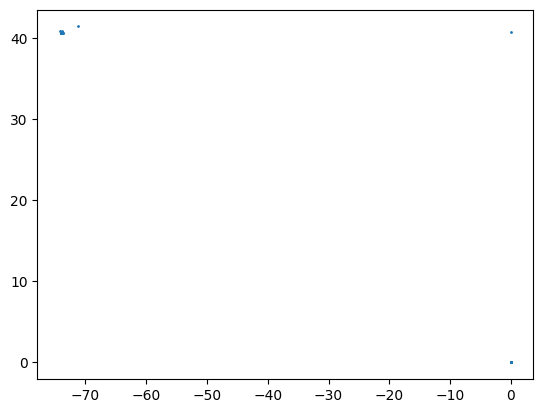

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Plotting all points is probably too much in many computers, so lets plot only a few 1000's
data = spark.sql( "SELECT * FROM data LIMIT 1000")
pickups = data.collect()

print('Plotting pickups')
plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            s=1)
plt.show()


### Plotting heatamps

This example shows how to **plot heatmaps** and how to **create a grid** with coordinates -- note that we need to group nearby coordinates together or (almost) every coordinate will be unique.

The example creates a grid, with cell of 150m of side (commented out the code for cells of 500m of side).

\[From ACM DEBS 2015 Grand Challenge page\]

**Question 1**: Is the earth flat or how to map coordinates to cells?

**Answer**: For the challenge we allow a simplified flat earth assumption for mapping coordinates to cells in the queries. You can assume that a distance of 500 meter south corresponds to a change of 0.004491556 degrees in the coordinate system. For moving 500 meter east you can assume a change of 0.005986 degrees in the coordinate system.

Plotting pickups


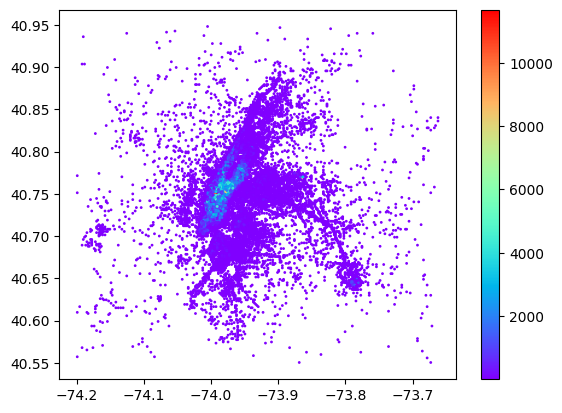

Plotting pickups


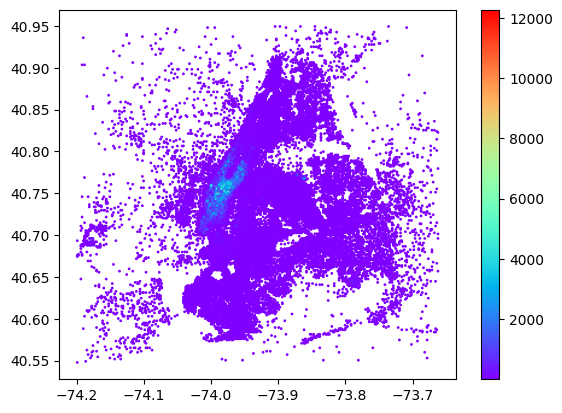

In [ ]:
# Squares of 500 meters
#latitudeStep = 0.004491556
#longitudeStep = 0.005986
#northLatitude = 41.474937 - 0.5 * latitudeStep
#southLatitude = northLatitude - 300 * latitudeStep
#eastLongitude = -74.913585 - 0.5 * longitudeStep
#westLongitude = eastLongitude + 300 * longitudeStep

# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            c=[row.cnt for row in pickups],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

# Statistics for pickups
dropoffsDF = spark.sql( """SELECT dropoff_longitude, dropoff_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY dropoff_longitude, dropoff_latitude""")
dropoffs = dropoffsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.dropoff_longitude for row in dropoffs],
            [row.dropoff_latitude for row in dropoffs],
            c=[row.cnt for row in dropoffs],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()



## Exercise 1: simple statistics

Compute, for each license, the total amount of money collected.

Comapre the time it takes to execute the code for Pandas, Spark Pandas API, Spark SQL and cuDF.

**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the small and long dataset.

### Code: Pandas library

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = pd.read_csv(FILENAME,names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 9.473926544189453


### Results (Pandas)

The time to process the small dataset was : **12.6570** seconds.

The time to process the large dataset was : **not possible** to run on my computer as there is not enough RAM. The error message below was given (in english "Your session failed after using all of available RAM"):
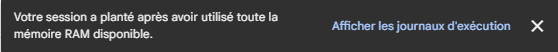

### Code: Spark Pandas API

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = ps.read_csv(FILENAME,names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()
# force execution
result0 = result.to_spark().collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Runtime = 19.05531907081604


### Results (Spark Pandas API)

The time to process the small dataset was : **27.2467** seconds.

The time to process the large dataset was : **2053.4668** seconds (>34 min).

### Spark SQL

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT hack_license, SUM(total_amount) AS total_amount FROM data GROUP BY hack_license""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 8.465018510818481


### Results (Spark)

The time to process the small dataset was : **9.9089** seconds.

The time to process the large dataset was : more than **4228.9453** seconds (>70 minutes)

### Code: cuDF

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = cudf.read_csv(FILENAME, names=mySchema)
result = dataset[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


RuntimeError: CUDF failure at: /__w/cudf/cudf/cpp/src/io/comp/uncomp.cpp:295: ZLIB decompression failed

### Results (cuDF)

The time to process the small dataset was : 2.2156 seconds.

The time to process the large dataset was : **Impossible to open**. Indeed, I think there is a problem with the compression of the file (compressed but unsupported? corrupted? not actually compressed?) because the cuDF code above works for the small and tiny datasets, but not for the large one.
"CUDF failure at: (...) ZLIB decompression failed"

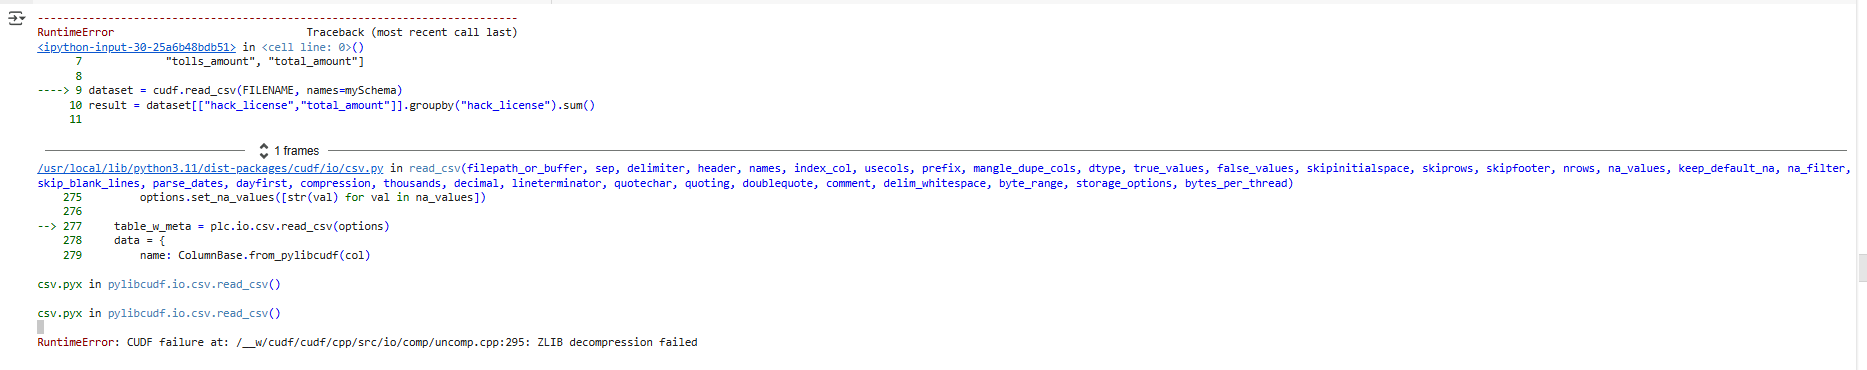

### Results discussion

CPU used for pandas, spark pandas api, spark sql api

GPU used for cuDF only

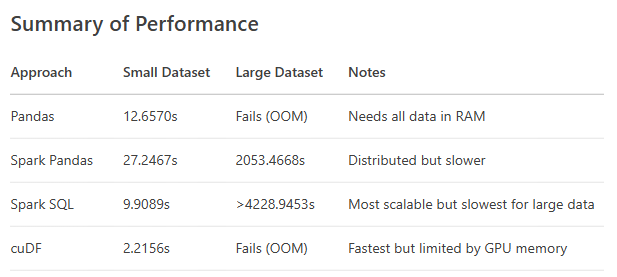


From the results, we can see that **Pandas** performs reasonably well on small datasets, completing the operation in about 12.6 seconds. This is expected, as Pandas operates entirely in-memory with minimal overhead. However, it fails on large datasets due to out-of-memory (OOM) errors, since it attempts to load the entire dataset into RAM. This makes it unsuitable for large-scale data unless a machine with a substantial amount of memory is used.

The **Pandas API on Spark** offers a familiar syntax as Pandas, while leveraging Spark’s distributed capabilities. However, it proved to be quite slow—over 27 seconds for the small dataset and more than 34 minutes for the large dataset. While it avoids memory limitations by distributing the computation, it incurs overhead from abstraction and execution planning.

**Spark SQL** was faster than the Pandas API on Spark and Pandas for the small dataset (around 9.9 seconds) and significantly slower on the large one (over 70 minutes). Despite this, it remains the most scalable in terms of architecture, as it is designed for distributed computation on large datasets. Its performance depends heavily on how well the Spark engine is configured and how efficiently queries are written.

**cuDF**, which utilizes GPU acceleration, showed the fastest performance on the small dataset at just 2.2 seconds. However, it failed to process the large dataset due to a decompression issue related to ZLIB. In general, cuDF has great potential for large-scale processing if the dataset fits in GPU memory and is in a compatible format. Theoretically, cuDF must yield the lowest time needed for the computation on the large dataset but it seems that the file is corrupted (for cuDF only though)

In summary, each tool has trade-offs. Pandas is convenient but limited by memory. The Spark-based approaches offer scalability but can be slower due to overhead. cuDF is very fast but constrained by GPU memory and sensitive to data formatting. The best choice depends on dataset size, hardware resources, and familiarity with each tool’s programming model.





## Exercise 2

The code presented in the **Plotting heatmap** section includes the call to an registered Python UDF function. In this exercise we want to measure the impact of using the UDF function.

Run this exercise with the small dataset.

In [ ]:
start_time = time.time()
# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 13.236587524414062


**Results (Spark SQL with UDF Python function)**

The time to process the small dataset was : **18.9698** seconds.

Write the code in Spark SQL without using the auxiliary function.

In [ ]:
# TO COMPLETE
start_time = time.time()
# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql(f"""
    SELECT medallion, hack_license, pickup_datetime,
           dropoff_datetime, trip_time_in_secs, trip_distance,
           FLOOR((pickup_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} + {eastLongitude} + {longitudeStep}/2 AS pickup_longitude,
           {northLatitude} - (FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} + {latitudeStep}/2) AS pickup_latitude,
           FLOOR((dropoff_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} + {eastLongitude} + {longitudeStep}/2 AS dropoff_longitude,
           {northLatitude} - (FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} + {latitudeStep}/2) AS dropoff_latitude,
           payment_type, fare_amount, mta_tax,
           tip_amount, tolls_amount, total_amount
    FROM data
    WHERE pickup_longitude >= {eastLongitude} AND
          pickup_longitude <= {westLongitude} AND
          dropoff_longitude >= {eastLongitude} AND
          dropoff_longitude <= {westLongitude} AND
          pickup_latitude <= {northLatitude} AND
          pickup_latitude >= {southLatitude} AND
          dropoff_latitude <= {northLatitude} AND
          dropoff_latitude >= {southLatitude}
""")

filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql("""
    SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
    FROM data
    GROUP BY pickup_longitude, pickup_latitude
""")
pickups = pickupsDF.collect()

end_time = time.time()

print("Runtime = " + str(end_time - start_time))


Runtime = 9.67947506904602


**Results (Spark SQL with no UDF Python function)**

The time to process the small dataset was : **11.0046** seconds.




### Discussion of results

*Performance Comparison*

With UDFs (Python functions): Runtime = 18.97 seconds

Without UDFs (Pure Spark SQL): Runtime = 11.00 seconds

The Spark SQL-only approach is ~42% faster than using Python UDFs.

This aligns with the best practice that native Spark SQL functions or generally libraries functions are more efficient than Python UDFs. Indeed, Python UDFs should be avoided for performance-critical workloads whenever possible because:


**Serialization Overhead**

Python UDFs require serialization between JVM (Spark) and Python, adding latency.

Native Spark SQL avoids this by operating entirely within the JVM.

**Optimization Limitations**

Spark’s Catalyst optimizer cannot optimize UDFs (treated as "black boxes").

SQL expressions (e.g., FLOOR, arithmetic) are optimized via predicate pushdown and constant folding.

**Execution Model**

UDFs: Row-by-row processing in Python (slow iteration).

Spark SQL: Vectorized operations parallelized across partitions.

**Type Safety**

UDFs risk implicit type conversions (e.g., Python float → Spark DoubleType).

Native SQL enforces strict type handling during query planning.

## Exercise 3

Let's start by trying to help the city to identify which new express bus routes shoud introduce. To this end, you should find the 20 most frequent routes whose distance is above a given treshold (defined by you).

For establishing these routes, we suggest that you use a grid of 500m of side.

Write two solutions: one using Spark SQL and the other Spark Pandas API.

In [ ]:

# Grid parameters (500m squares) - based on DEBS Grand Challenge specifications
latitudeStep = 0.004491556  # 500m in latitude degrees
longitudeStep = 0.005986    # 500m in longitude degrees
northLatitude = 41.474937 - 0.5 * latitudeStep
southLatitude = northLatitude - 300 * latitudeStep  # Covers ~150km south
eastLongitude = -74.913585 - 0.5 * longitudeStep
westLongitude = eastLongitude + 300 * longitudeStep  # Covers ~150km east

# Distance threshold for express bus routes (5 miles ≈ 8km)
distance_threshold = 5.0

# Initialize Spark session

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("BusRoute") \
    .getOrCreate()


# Dataset schema matching the NYC taxi data format
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

# Load dataset and create temporary view
dataset = spark.read.load(
    FILENAME,
    format="csv",
    sep=",",
    schema=mySchema,
    header="false"
)

# Register the dataset as a temporary view
dataset.createOrReplaceTempView("trips")


In [ ]:
start_time = time.time()

top_routes_sql = spark.sql(f"""
    WITH filtered_trips AS (
        SELECT *
        FROM trips
        WHERE trip_distance > {distance_threshold}
          AND pickup_longitude BETWEEN {eastLongitude} AND {westLongitude}
          AND pickup_latitude BETWEEN {southLatitude} AND {northLatitude}
          AND dropoff_longitude BETWEEN {eastLongitude} AND {westLongitude}
          AND dropoff_latitude BETWEEN {southLatitude} AND {northLatitude}
    ),
    rounded_trips AS (
        SELECT
            -- Round pickup coordinates to nearest 500m grid center
            FLOOR((pickup_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} + {eastLongitude} + {longitudeStep}/2 AS pickup_long,
            {northLatitude} - (FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} + {latitudeStep}/2) AS pickup_lat,
            -- Round dropoff coordinates
            FLOOR((dropoff_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} + {eastLongitude} + {longitudeStep}/2 AS dropoff_long,
            {northLatitude} - (FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} + {latitudeStep}/2) AS dropoff_lat
        FROM filtered_trips
    ),
    route_counts AS (
        SELECT
            CONCAT(ROUND(pickup_long, 6), ',', ROUND(pickup_lat, 6),
                  ' → ',
                  ROUND(dropoff_long, 6), ',', ROUND(dropoff_lat, 6)) AS route,
            COUNT(*) AS frequency,
            ROUND(AVG(SQRT(
                POWER((pickup_long - dropoff_long)/{longitudeStep}*500, 2) +
                POWER((pickup_lat - dropoff_lat)/{latitudeStep}*500, 2)
            )), 2) AS avg_distance_meters,
            ROUND(AVG(SQRT(
                POWER((pickup_long - dropoff_long)/{longitudeStep}*500, 2) +
                POWER((pickup_lat - dropoff_lat)/{latitudeStep}*500, 2)
            )) / 1609.34, 2) AS avg_distance_miles
        FROM rounded_trips
        GROUP BY pickup_long, pickup_lat, dropoff_long, dropoff_lat
    )
    SELECT route, frequency, avg_distance_miles, avg_distance_meters
    FROM route_counts
    ORDER BY frequency DESC
    LIMIT 20
""")

print("Top 20 Frequent Routes (Spark SQL):")
top_routes_sql.show(truncate=False, n=20)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Top 20 Frequent Routes (Spark SQL):
+-------------------------------------------+---------+------------------+-------------------+
|route                                      |frequency|avg_distance_miles|avg_distance_meters|
+-------------------------------------------+---------+------------------+-------------------+
|-73.872021,40.774254 → -73.973783,40.756288|667      |5.43              |8732.12            |
|-73.985755,40.760780 → -73.872021,40.774254|526      |5.98              |9617.69            |
|-73.872021,40.774254 → -73.979769,40.760780|504      |5.67              |9124.14            |
|-73.872021,40.774254 → -73.985755,40.760780|499      |5.98              |9617.69            |
|-73.872021,40.774254 → -73.985755,40.756288|497      |6.03              |9708.24            |
|-73.872021,40.774254 → -73.973783,40.751796|481      |5.51              |8860.02            |
|-73.979769,40.760780 → -73.872021,40.774254|452      |5.67              |9124.14            |
|-73.973783,40

In [ ]:
start_time = time.time()
# Spark Pandas API Solution (Confirmed Working)
import pyspark.pandas as ps
import numpy as np

# Convert to Spark Pandas DataFrame
trips_ps = ps.DataFrame(dataset)

# Filter relevant trips
filtered = trips_ps[
    (trips_ps.trip_distance > distance_threshold) &
    (trips_ps.pickup_longitude.between(eastLongitude, westLongitude)) &
    (trips_ps.pickup_latitude.between(southLatitude, northLatitude)) &
    (trips_ps.dropoff_longitude.between(eastLongitude, westLongitude)) &
    (trips_ps.dropoff_latitude.between(southLatitude, northLatitude))
]

# Calculate grid coordinates
filtered = filtered.assign(
    pickup_grid_long = ((filtered.pickup_longitude - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep/2,
    pickup_grid_lat = northLatitude - ((northLatitude - filtered.pickup_latitude) // latitudeStep) * latitudeStep - latitudeStep/2,
    dropoff_grid_long = ((filtered.dropoff_longitude - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep/2,
    dropoff_grid_lat = northLatitude - ((northLatitude - filtered.dropoff_latitude) // latitudeStep) * latitudeStep - latitudeStep/2
)

# Group and aggregate
route_counts = filtered.groupby([
    "pickup_grid_long", "pickup_grid_lat",
    "dropoff_grid_long", "dropoff_grid_lat"
]).agg(
    frequency=("trip_distance", "count"),
    avg_distance=("trip_distance", "mean")
).reset_index()

# Calculate distances
long_diff = (route_counts["pickup_grid_long"] - route_counts["dropoff_grid_long"]) / longitudeStep * 500
lat_diff = (route_counts["pickup_grid_lat"] - route_counts["dropoff_grid_lat"]) / latitudeStep * 500
route_counts = route_counts.assign(
    distance_meters = np.sqrt(long_diff**2 + lat_diff**2).round(2)
)

# Format route strings
route_counts = route_counts.assign(
    route = (
        route_counts["pickup_grid_long"].round(6).astype(str) + "," +
        route_counts["pickup_grid_lat"].round(6).astype(str) + " → " +
        route_counts["dropoff_grid_long"].round(6).astype(str) + "," +
        route_counts["dropoff_grid_lat"].round(6).astype(str)
    )
)

# Get top 20 routes
top_routes_ps = route_counts.sort_values("frequency", ascending=False).head(20)[
    ["route", "frequency", "distance_meters"]
]

# Final formatting
top_routes_ps = top_routes_ps.rename(columns={"distance_meters": "avg_distance_meters"})
top_routes_ps = top_routes_ps.assign(
    avg_distance_miles=(top_routes_ps["avg_distance_meters"] / 1609.34).round(2)
)

print("\nTop 20 Frequent Routes (Spark Pandas API):")
display(top_routes_ps[["route", "frequency", "avg_distance_miles", "avg_distance_meters"]])

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)



Top 20 Frequent Routes (Spark Pandas API):


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,route,frequency,avg_distance_miles,avg_distance_meters
2841,"-73.872021,40.774254 → -73.973783,40.756288",667,5.43,8732.12
34093,"-73.985755,40.76078 → -73.872021,40.774254",526,5.98,9617.69
50361,"-73.872021,40.774254 → -73.979769,40.76078",504,5.67,9124.14
2419,"-73.872021,40.774254 → -73.985755,40.76078",499,5.98,9617.69
29751,"-73.872021,40.774254 → -73.985755,40.756288",497,6.03,9708.24
21404,"-73.872021,40.774254 → -73.973783,40.751796",481,5.51,8860.02
49883,"-73.979769,40.76078 → -73.872021,40.774254",452,5.67,9124.14
27690,"-73.973783,40.756288 → -73.872021,40.774254",424,5.43,8732.12
46795,"-73.872021,40.774254 → -73.979769,40.765271",421,5.63,9055.39
13530,"-73.866035,40.769763 → -73.973783,40.756288",402,5.67,9124.14


Runtime = 36.7433123588562


#### Discussion

In this exercise, we explored two approaches for identifying the 20 most frequent long-distance routes that could be used to propose new express bus lines. Both solutions used a 500-meter grid to discretize the city into manageable route segments and computed route frequencies and average distances. The main difference lies in how the computation is expressed and executed: one using Spark SQL and the other using the Spark Pandas API.

The Spark SQL approach reflects a declarative data analysis model where we express what we want to compute rather than how. It leverages Spark’s SQL execution engine to optimize the computation through query planning and execution DAGs. This method is closer to the traditional batch processing model discussed in class, where all transformations (filter, group by, aggregation) are compiled into a single distributed execution plan. This reduces data movement and allows Spark to apply physical optimizations such as predicate pushdown and data locality-aware scheduling. This approach also naturally supports many-to-one transformations like groupby-aggregation, which are common in route frequency analysis.

In contrast, the Spark Pandas API provides a procedural programming model with a syntax similar to standard Pandas. While it allows for more step-by-step logic and is easier to grasp for those familiar with Python, it introduces additional layers of abstraction. Even though it is translated into distributed Spark jobs, this translation can be less efficient due to intermediate DataFrame materialization and wider dependencies between transformations. As covered in Lecture 3, wide dependencies (e.g., groupBy) involve significant data shuffling across machines, which can become a bottleneck. Also, since the Pandas API mimics row-wise and column-wise operations, it may not always benefit from Spark’s execution optimizations unless used carefully.

**Performance Comparison**

The runtime for the Spark SQL solution was approximately 9.83 seconds, while the Spark Pandas API approach took 34.79 seconds. This means that Spark SQL performed more than 3.5 times faster on the same task.

This performance gap is consistent with what we’ve learned: Spark SQL benefits from query optimization, vectorized execution, and more efficient memory and data exchange handling. Meanwhile, the Spark Pandas API, while convenient, may suffer from performance overhead due to less optimized execution plans and more frequent materialization of intermediate results.

**Conclusion**

From a practical point of view, the Spark Pandas API is great for quick prototyping and readability, especially in smaller datasets or when the developer prefers a Pandas-like environment. However, for larger datasets or when performance and scalability are priorities, Spark SQL is more appropriate because it is optimized for distributed execution and minimizes unnecessary data transfers.

Therefore, although both approaches lead to the same analytical outcome, I consider the Spark SQL method preferable in terms of execution efficiency and scalability, especially in a production or big data setting as emphasized in our lectures. It aligns better with the principles of distributed computing and the optimization capabilities offered by Spark’s execution engine.



## Exercise 4

This question intends to define the location of taxi ranks / taxi stand (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to walk to reach a taxi rank.

Run this exercise with the small dataset and compare the execution time when using scikit-learn, cuML and Spark MLib.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, you should focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). Use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92
```

**Suggestion:** Plot your results as a heatmap, with the color being a measurement of the value of the taxi rank.

In [ ]:
#=== Preparing the Data===

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter

# Clustering and preprocessing from Scikit-learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# cuML for GPU-accelerated clustering
from cuml.cluster import KMeans as cuKMeans
import cupy as cp

# === Geographic Boundaries for NYC Region (Manhattan area) ===
north_lat = 40.86
south_lat = 40.68
east_lon = -73.92
west_lon = -74.03

# === Clustering Configuration ===
N_CLUSTERS = 20  # Number of clusters to form

# === Define Dataset Schema ===
# Column names correspond to fields in the NYC Taxi dataset
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

# === Load and Filter Dataset ===
# Load CSV file and assign schema
df = pd.read_csv(FILENAME, names=mySchema)

# Filter rows based on geographic bounding box (approximate Manhattan area)
df = df[(df['pickup_latitude'] >= south_lat) & (df['pickup_latitude'] <= north_lat) &
        (df['pickup_longitude'] >= west_lon) & (df['pickup_longitude'] <= east_lon)]

# === Prepare Coordinates for Clustering ===
# Select pickup latitude and longitude
coords = df[['pickup_latitude', 'pickup_longitude']].values

# Standardize features before clustering (mean = 0, variance = 1)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)


In [ ]:
# === Scikit-Learn: KMeans Clustering on CPU ===

start_time = time.time()

# Initialize and fit KMeans model with specified number of clusters
# - n_init defines how many times the algorithm will run with different centroid seeds
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(coords_scaled)

end_time = time.time()
runtime_scikit_learn = end_time - start_time

# Display runtime
print(f"KMeans clustering completed in {runtime_scikit_learn:.2f} seconds.")

KMeans clustering completed in 76.44 seconds.


<ipython-input-8-8e37e4213a2f>:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


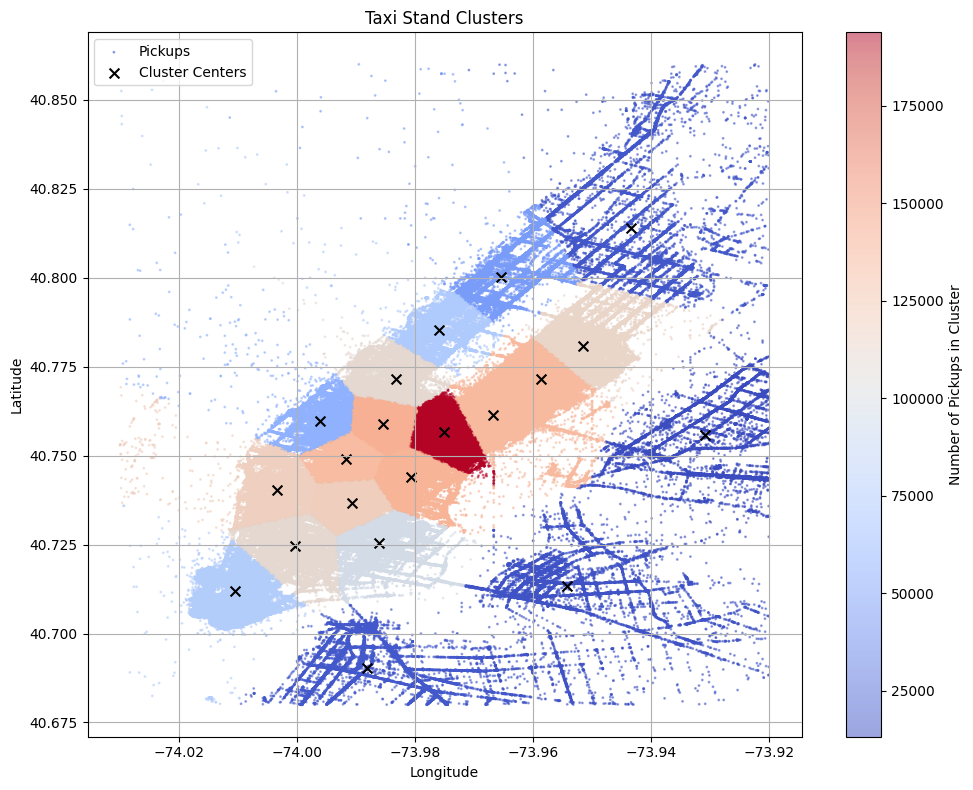

In [ ]:
# ===Plot Clustering Results ===

# Get cluster labels assigned to each data point
labels = kmeans.labels_

# Transform cluster centroids back to original coordinate scale (undo standardization)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Count the number of pickups assigned to each cluster
cluster_counts = Counter(labels)

# Map each pickup to its corresponding cluster's count (used for color intensity)
pickup_counts = [cluster_counts[label] for label in labels]


# Normalize pickup counts to create a continuous color scale
norm = plt.Normalize(vmin=min(pickup_counts), vmax=max(pickup_counts))
cmap = plt.cm.coolwarm

# Map normalized counts to color values
colors = cmap(norm(pickup_counts))

plt.figure(figsize=(10, 8))

# Plot all pickup points, colored by pickup density
scatter = plt.scatter(df['pickup_longitude'], df['pickup_latitude'],
                      c=pickup_counts, cmap='coolwarm', s=1, alpha=0.5, label='Pickups')

# Overlay cluster centers on the map
plt.scatter(centroids[:, 1], centroids[:, 0], c='black', s=50, marker='x', label='Cluster Centers')

# Add plot details
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Taxi Stand Clusters')
plt.colorbar(scatter, label='Number of Pickups in Cluster')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === cuML: GPU-Accelerated KMeans Clustering ===

# Convert standardized coordinates to CuPy array for GPU processing
coords_gpu = cp.asarray(coords_scaled)

start_time = time.time()

# Initialize and fit cuML's GPU-based KMeans model
kmeans = cuKMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
kmeans.fit(coords_gpu)

end_time = time.time()
runtime = end_time - start_time

# Display runtime
print(f"cuML KMeans clustering completed in {runtime:.2f} seconds.")

cuML KMeans clustering completed in 13.63 seconds.


<ipython-input-5-69688d9feb05>:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


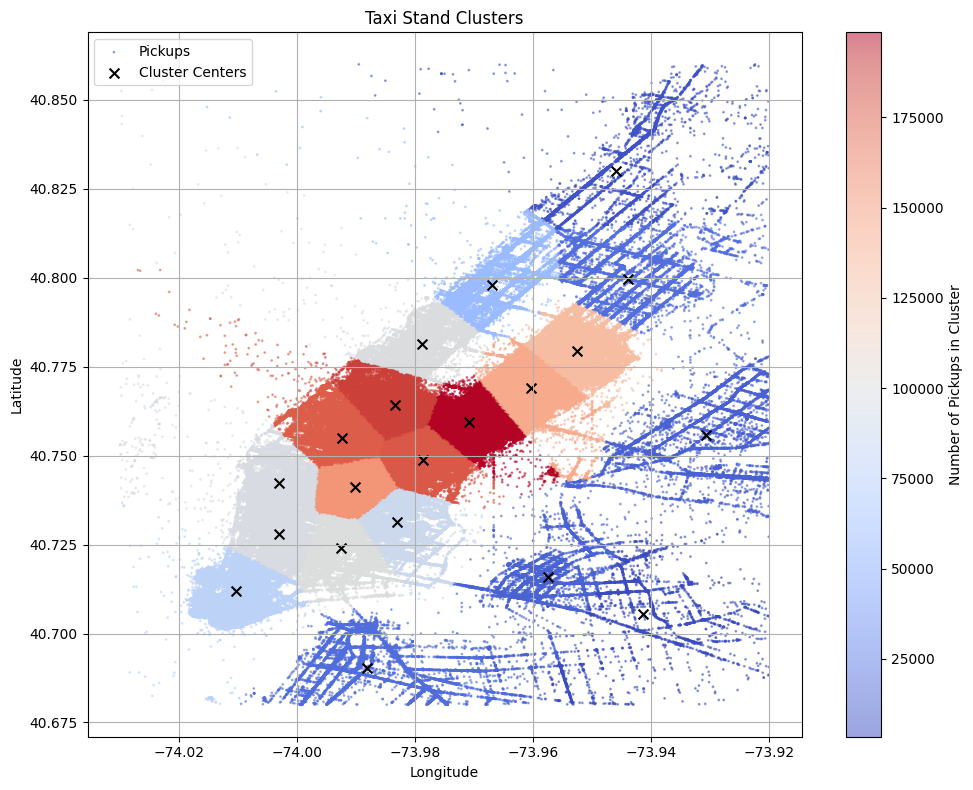

In [ ]:
# ===Plot Clustering Results ===

# Get cluster labels and centroids
labels = cp.asnumpy(kmeans.labels_)
centroids = scaler.inverse_transform(cp.asnumpy(kmeans.cluster_centers_))


# Count pickups per cluster
cluster_counts = Counter(labels)
pickup_counts = [cluster_counts[label] for label in labels]

# Normalize pickup counts for color hue
norm = plt.Normalize(vmin=min(pickup_counts), vmax=max(pickup_counts))
cmap = plt.cm.coolwarm
colors = cmap(norm(pickup_counts))

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['pickup_longitude'], df['pickup_latitude'],
                      c=pickup_counts, cmap='coolwarm', s=1, alpha=0.5, label='Pickups')

plt.scatter(centroids[:, 1], centroids[:, 0], c='black', s=50, marker='x', label='Cluster Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Taxi Stand Clusters')
plt.colorbar(scatter, label='Number of Pickups in Cluster')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === Data Preparation for Spark Mlib ===

# Import Required Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType
)
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# === Configuration Parameters ===
# NYC geographic bounds for Manhattan area
north_lat = 40.86
south_lat = 40.68
east_lon = -73.92
west_lon = -74.03
N_CLUSTERS = 20

# === Initialize Spark Session ===
spark = SparkSession.builder.appName("TaxiCluster").getOrCreate()

# === Define Schema for NYC Taxi Dataset ===
schema = StructType([
    StructField("medallion", StringType(), True),
    StructField("hack_license", StringType(), True),
    StructField("pickup_datetime", StringType(), True),
    StructField("dropoff_datetime", StringType(), True),
    StructField("trip_time_in_secs", DoubleType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True),
    StructField("payment_type", StringType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("surcharge", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("total_amount", DoubleType(), True)
])

# === Load CSV into Spark DataFrame ===
df_spark = spark.read.csv(FILENAME, header=False, schema=schema)

# === Filter Data by Geographic Bounding Box ===
df_filtered = df_spark.filter(
    (col("pickup_latitude") >= south_lat) &
    (col("pickup_latitude") <= north_lat) &
    (col("pickup_longitude") >= west_lon) &
    (col("pickup_longitude") <= east_lon)
).select("pickup_latitude", "pickup_longitude")

# Cache the filtered DataFrame for performance
df_filtered.cache()

# === Assemble Features for Clustering ===
vec_assembler = VectorAssembler(
    inputCols=["pickup_latitude", "pickup_longitude"],
    outputCol="features"
)
df_features = vec_assembler.transform(df_filtered)

# === Scale Features (Zero Mean, Unit Variance) ===
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

In [ ]:
# Spark Mklib: KMeans Clustering on CPU
start_time = time.time()

kmeans = KMeans(
    featuresCol="scaledFeatures",
    predictionCol="cluster",
    k=N_CLUSTERS,
    seed=42
)
model = kmeans.fit(df_scaled)

end_time = time.time()
runtime = end_time - start_time

# Display runtime
print(f"Spark Mlib KMeans clustering completed in {runtime:.2f} seconds.")

Spark Mlib KMeans clustering completed in 33.35 seconds.


<ipython-input-8-6757ae9c4ab4>:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


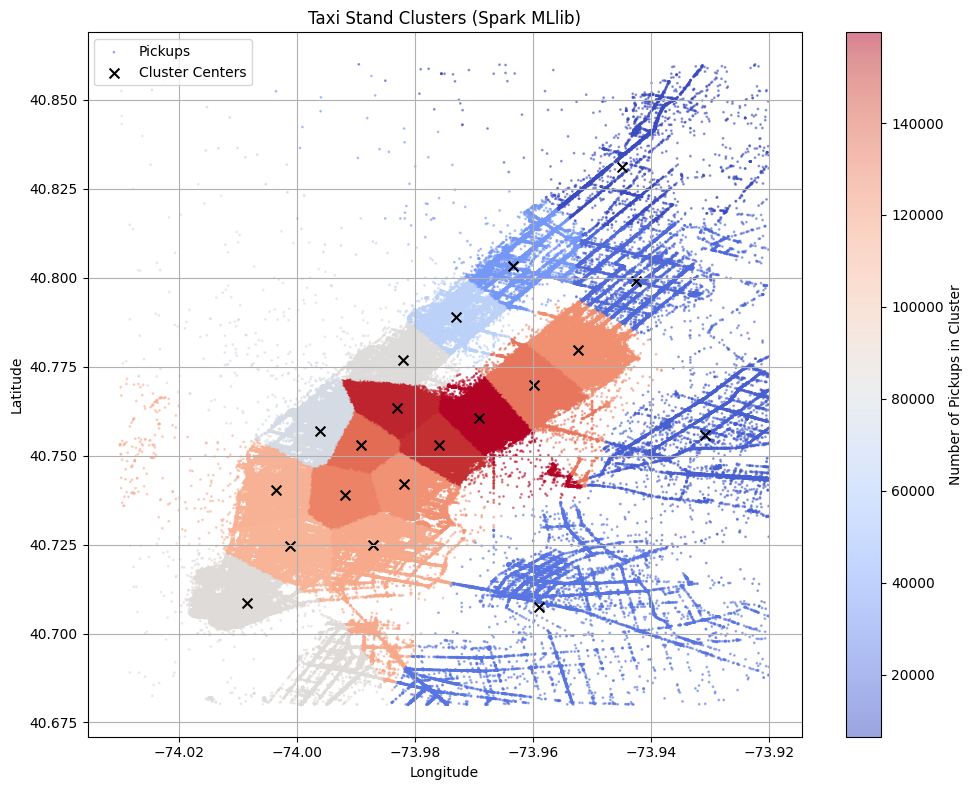

In [ ]:
# ===Plot Clustering Results ===
from collections import Counter

#  Get Predictions from Spark and convert to Pandas
df_result = model.transform(df_scaled).select(
    "pickup_latitude", "pickup_longitude", "cluster"
)

# Collect to Pandas
pdf_result = df_result.toPandas()

# Inverse-transform cluster centers
# Get Spark MLlib cluster centers in scaled space
scaled_centers = np.array(model.clusterCenters())

# Convert to original scale using scaler_model
centers_unscaled = scaler_model.mean.toArray() + scaler_model.std.toArray() * scaled_centers

# Count pickups per cluster
cluster_counts = Counter(pdf_result['cluster'])

# Map each point to cluster pickup count
pickup_counts = [cluster_counts[label] for label in pdf_result['cluster']]

# Normalize pickup counts for color mapping
norm = plt.Normalize(vmin=min(pickup_counts), vmax=max(pickup_counts))
cmap = plt.cm.coolwarm
colors = cmap(norm(pickup_counts))

# Step 5: Plotting
plt.figure(figsize=(10, 8))

# Plot all pickups colored by cluster density
scatter = plt.scatter(pdf_result['pickup_longitude'], pdf_result['pickup_latitude'],
                      c=pickup_counts, cmap='coolwarm', s=1, alpha=0.5, label='Pickups')

# Overlay cluster centers
plt.scatter(centers_unscaled[:, 1], centers_unscaled[:, 0],
            c='black', s=50, marker='x', label='Cluster Centers')

# Labels and aesthetics
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Taxi Stand Clusters (Spark MLlib)')
plt.colorbar(scatter, label='Number of Pickups in Cluster')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Execution times (seconds)**

scikit-learn: **76.4**

cuML: **13.6**

Spark Mlib: **33.4**


#### **Discussion**

1. **Why is this a clustering problem?**
The objective is to group taxi pickup points based on spatial proximity without predefined labels, which makes it a classic unsupervised learning problem. In this setup, the center of each cluster can be interpreted as an ideal taxi stand location, as it minimizes the within-cluster distance, making it the most logical and efficient point for clients to find a cab.

2. **Why KMeans instead of hierarchical clustering or DBSCAN?**
KMeans was selected due to its high parallelizability, scalability, and availability across all three frameworks (Scikit-Learn, cuML, and Spark MLlib). While DBSCAN handles noise and arbitrary cluster shapes well, it involves sequential neighbor-based operations, making it less suitable for parallel processing on large datasets. Hierarchical clustering was ruled out due to its high computational cost with datasets of this size (~2 million events).

3. **Why use Euclidean distance and not Manhattan?**
Euclidean distance was used because Manhattan distance is not supported in cuML and Spark MLlib. While Manhattan distance might better approximate city block travel (e.g., NYC grid layout), this analysis focused on comparing performance across implementations, not on modeling real-world routing. Thus, Euclidean distance was an acceptable and practical choice.

4. **Why set the number of clusters to 20?**
A fixed number of 20 clusters was used to ensure consistency and comparability across all methods. Although using the elbow method or silhouette score would help identify the optimal number of clusters, these methods were computationally intensive and not aligned with the exercise’s goal of comparing method efficiency.

5. **Comments on the visualization**
The results were visualized using a coolwarm colormap, where color intensity reflects the density of pickups within each cluster—hotter colors indicate areas with more activity



**Performance**

In comparing the runtime performance of KMeans clustering across different frameworks using a dataset of approximately 2 million events (roughly 130 MB in size), cuML emerged as the fastest, completing the task in just 13 seconds. This performance is largely due to its ability to harness GPU acceleration, making it highly efficient for medium-sized datasets that fit within GPU memory. In contrast, Spark MLlib took 33 seconds, benefiting from distributed CPU processing, which is well-suited for large-scale data but introduces overhead that makes it slower than GPU-based solutions for datasets of this size. Scikit-Learn, running on a single CPU core, was the slowest at 76 seconds, lacking hardware acceleration or distributed computing capabilities. Nevertheless, it remains a popular choice for quick prototyping and analysis when simplicity and interpretability are key. Overall, for datasets in the range of a few million records, cuML offers the best performance in GPU environments, Spark is better suited for scaling to even larger datasets, and Scikit-Learn is ideal for accessible local experimentation.